In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchviz import make_dot
from pathlib import Path

In [2]:
iw_path = str(Path.home() / "Documents") + '/IW_Images/'
downloads_path = str(Path.home() / "Downloads")

In [3]:
df = pd.read_pickle(downloads_path + '/COS398/data_w_correct_cols.pkl')
for i in df.columns[5:-1]:
    df[i] = df[i].str.replace('%','').astype('double') 
df = df.T.dropna().T

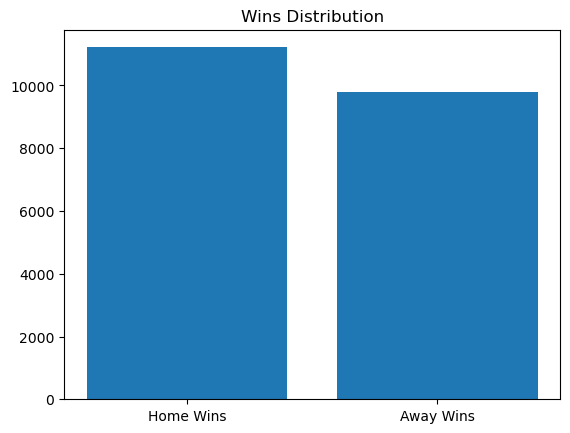

In [4]:
plt.bar(x = ['Home Wins','Away Wins'], height = df.Target.value_counts().values)

plt.title('Wins Distribution')

plt.savefig(iw_path + 'wins.eps')
# plt

In [5]:
X,y = df.iloc[:,5:-1],df.Target

In [6]:
from sklearn.feature_selection import f_classif

In [7]:
f_stat,p_vals = f_classif(X,y)[0],f_classif(X,y)[1]

In [8]:
stat_df = pd.DataFrame()
stat_df['cols'] = X.columns
stat_df['f_stat'] = f_stat
stat_df['p_vals'] = p_vals

In [9]:
all_cols = stat_df.sort_values(by = 'f_stat',ascending = 0).cols.values

In [10]:
all_cols[:15]

array(['Away_Pit_ERA-', 'Home_Pit_ERA-', 'Away_Pit_ERA', 'Away_Pit_WHIP',
       'Home_Pit_ERA', 'Home_Pit_WHIP', 'Home_Hit_wRC+', 'Away_Pit_AVG',
       'Away_Pit_FIP-', 'Away_Hit_wRC+', 'Home_Hit_wOBA', 'Home_Hit_OBP',
       'Away_Pit_LOB%', 'Home_Pit_LOB%', 'Home_Hit_OPS'], dtype=object)

In [11]:
top_60 = np.percentile(stat_df[stat_df.p_vals <= .01].sort_values(by = 'f_stat',ascending =0).f_stat,60)

In [12]:
f_cols = stat_df[(stat_df.f_stat >= top_60) & (stat_df.p_vals < .01)].cols.values

In [13]:
advs = ['#',
 'Date',
 'Team',
 'PA',
 'BB%',
 'K%',
 'BB/K',
 'AVG',
 'OBP',
 'SLG',
 'OPS',
 'ISO',
 'Spd',
 'BABIP',
 'UBR',
 'wGDP',
 'wSB',
 'wRC',
 'wRAA',
 'wOBA',
 'wRC+',
 '#',
 'Date',
 'Team',
 'K/9',
 'BB/9',
 'K/BB',
 'HR/9',
 'K%',
 'BB%',
 'K-BB%',
 'AVG',
 'WHIP',
 'BABIP',
 'LOB%',
 'ERA-',
 'FIP-',
 'xFIP-',
 'ERA',
 'FIP',
 'E-F',
 'xFIP',
 'SIERA']

In [14]:
regs = ['#',
 'Date',
 'Team',
 'TG',
 'G',
 'AB',
 'PA',
 'H',
 '1B',
 '2B',
 '3B',
 'HR',
 'R',
 'RBI',
 'BB',
 'IBB',
 'SO',
 'HBP',
 'SF',
 'SH',
 'GDP',
 'SB',
 'CS',
 'AVG',
 '#',
 'Date',
 'Team',
 'TG',
 'W',
 'L',
 'ERA',
 'G',
 'GS',
 'CG',
 'ShO',
 'SV',
 'HLD',
 'BS',
 'IP',
 'TBF',
 'H',
 'R',
 'ER',
 'HR',
 'BB',
 'IBB',
 'HBP',
 'WP',
 'BK',
 'SO']

In [15]:
rregs = ['Home_Hit_' + x for x in regs] + ['Away_Hit_' + x for x in regs] + ['Home_Pit_' + x for x in regs] + ['Away_Pit_' + x for x in regs]

In [16]:
addvs = ['Home_Hit_' + x for x in advs] + ['Away_Hit_' + x for x in advs] + ['Home_Pit_' + x for x in advs] + ['Away_Pit_' + x for x in advs]

In [17]:
reg = [x for x in all_cols if x in rregs][:15]

In [18]:
adv = [x for x in all_cols if x in addvs][:15]

In [19]:
reg

['Away_Pit_ERA',
 'Home_Pit_ERA',
 'Away_Pit_AVG',
 'Home_Pit_AVG',
 'Home_Hit_AVG',
 'Away_Hit_AVG',
 'Away_Pit_L',
 'Home_Pit_W',
 'Away_Pit_W',
 'Home_Pit_L',
 'Home_Pit_SV',
 'Away_Pit_SV',
 'Away_Pit_ER',
 'Away_Pit_R',
 'Away_Pit_IBB']

In [20]:
adv

['Away_Pit_ERA-',
 'Home_Pit_ERA-',
 'Away_Pit_ERA',
 'Away_Pit_WHIP',
 'Home_Pit_ERA',
 'Home_Pit_WHIP',
 'Home_Hit_wRC+',
 'Away_Pit_AVG',
 'Away_Pit_FIP-',
 'Away_Hit_wRC+',
 'Home_Hit_wOBA',
 'Home_Hit_OBP',
 'Away_Pit_LOB%',
 'Home_Pit_LOB%',
 'Home_Hit_OPS']

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_non_train, y_train,y_non_train = train_test_split(X[f_cols],y,train_size=.60,random_state = 50)
X_val, X_test, y_val,y_test = train_test_split(X_non_train,y_non_train,train_size=.50,random_state = 50)

In [22]:
import torch
# !pip install seaborn
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F

In [23]:
class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 90)
    self.fc2 = nn.Linear(90, 50)
    self.fc3 = nn.Linear(50, 30)
    self.fc4 = nn.Linear(30, 10)
#     self.dropout = nn.Dropout(p=0.5)
    self.fc5 = nn.Linear(10, 1)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    return torch.sigmoid(self.fc5(x))
#     return self.fc5(x)
net = Net(X_train.shape[1])
graph = make_dot(net(torch.randn((1, X_train.shape[1]))), params=dict(net.named_parameters()))
graph.render(filename=iw_path + 'f_cols', format='eps')

'/Users/tonyowens/Documents/IW_Images/f_cols.eps'

In [24]:
X_train = torch.from_numpy(X_train.astype(float).to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.astype(bool).to_numpy()).float())

X_val = torch.from_numpy(X_val.astype(float).to_numpy()).float()
y_val = torch.squeeze(torch.from_numpy(y_val.astype(bool).to_numpy()).float())

X_test = torch.from_numpy(X_test.astype(float).to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.astype(bool).to_numpy()).float())

In [25]:
# criterion = nn.HingeEmbeddingLoss()
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(net.parameters(), lr=1e-2)
optimizer = optim.ASGD(net.parameters(),lr = 1e-2)

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
net = net.to(device)
criterion = criterion.to(device)

In [27]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [28]:
# on 12k
train_acc_arr1 = []
test_acc_arr1 = []
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)
max_val_err = np.inf
for epoch in range(100_001):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    if epoch % 1000 == 0:
        train_acc = calculate_accuracy(y_train, y_pred)
        y_test_pred = net(X_val)
        y_test_pred = torch.squeeze(y_test_pred)
        test_loss = criterion(y_test_pred,y_val)
        test_acc = calculate_accuracy(y_val, y_test_pred)
        print(
        f'''epoch {epoch}
        Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
        Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
        ''')
        train_acc_arr1.append(np.round(np.float64(train_acc),3))
        test_acc_arr1.append(np.round(np.float64(test_acc),3))
    if test_loss < max_val_err:
        max_val_err = test_loss
        best_state = net.state_dict()
    for param in net.parameters():   
        param.grad = None
    train_loss.backward()
    optimizer.step()

epoch 0
        Train set - loss: 0.711, accuracy: 0.472
        Test  set - loss: 0.705, accuracy: 0.492
        
epoch 1000
        Train set - loss: 0.659, accuracy: 0.599
        Test  set - loss: 0.665, accuracy: 0.593
        
epoch 2000
        Train set - loss: 0.657, accuracy: 0.603
        Test  set - loss: 0.664, accuracy: 0.593
        
epoch 3000
        Train set - loss: 0.656, accuracy: 0.605
        Test  set - loss: 0.664, accuracy: 0.593
        
epoch 4000
        Train set - loss: 0.656, accuracy: 0.607
        Test  set - loss: 0.664, accuracy: 0.593
        
epoch 5000
        Train set - loss: 0.655, accuracy: 0.607
        Test  set - loss: 0.664, accuracy: 0.595
        
epoch 6000
        Train set - loss: 0.655, accuracy: 0.607
        Test  set - loss: 0.664, accuracy: 0.596
        
epoch 7000
        Train set - loss: 0.654, accuracy: 0.607
        Test  set - loss: 0.664, accuracy: 0.593
        
epoch 8000
        Train set - loss: 0.654, accuracy: 0.609

In [29]:
net1 = Net(X_train.shape[1])
# net1.load_state_dict(best_state)

In [30]:
net1.load_state_dict(best_state)

<All keys matched successfully>

In [31]:
# test_preds = net1(X_test)

In [32]:
test_preds = np.round(net1(X_test).detach().numpy())

In [33]:
calculate_accuracy(y_test,torch.squeeze(net1(X_test)))

tensor(0.5735)

In [34]:
a = np.array([])

In [35]:
b = np.array([])

In [36]:
for y1 in y_test:
    b = np.append(b,y1)

In [37]:
for pred in test_preds:
    a = np.append(a,pred)

In [38]:
from sklearn.metrics import accuracy_score
accq = accuracy_score(b,a)
print(accuracy_score(b,a))
combinedq = pd.DataFrame(dict(actual =b ,prediction = a))
pd.crosstab(index=combinedq["actual"], columns = combinedq["prediction"])

0.5735014272121789


prediction,0.0,1.0
actual,,
0.0,721,1255
1.0,538,1690


In [39]:
acc_df = pd.DataFrame()
acc_df['Training'] = np.array(train_acc_arr1) * 100
acc_df['Validation'] = np.array(test_acc_arr1) * 100

In [40]:
print("Max validation accuracy = %.2f",max(test_acc_arr1))

Max validation accuracy = %.2f 0.598


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


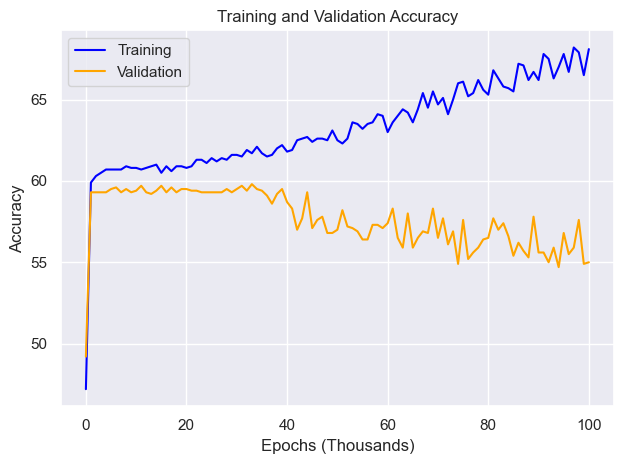

In [41]:
sns.set()
fig,ax = plt.subplots()
plt.plot([x * 100 for x in train_acc_arr1],c = 'blue',label = 'Training')
plt.plot([x * 100 for x in test_acc_arr1],c = 'orange',label = 'Validation')
leg = plt.legend(loc='upper left')
plt.xlabel('Epochs (Thousands)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
fig.tight_layout()
fig.savefig(iw_path + 'top_sig.eps')

In [42]:
X_train, X_non_train, y_train,y_non_train = train_test_split(X[reg],y,train_size=.60,random_state = 50)
X_val, X_test, y_val,y_test = train_test_split(X_non_train,y_non_train,train_size=.50,random_state = 50)

In [43]:
from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(current_sched[normal_cols])
scaler = StandardScaler().fit(X_train)

In [44]:
class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 60)
    self.fc2 = nn.Linear(60, 30)
    self.fc3 = nn.Linear(30, 10)
    self.fc4 = nn.Linear(10, 5)
    self.fc5 = nn.Linear(5, 1)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    return torch.sigmoid(self.fc5(x))
#     return self.fc5(x)
net = Net(X_train.shape[1])
graph = make_dot(net(torch.randn((1, len(reg)))), params=dict(net.named_parameters()))
graph.render(filename=iw_path + 'reg', format='eps')

'/Users/tonyowens/Documents/IW_Images/reg.eps'

In [45]:
# X_train = torch.from_numpy(X_train.to_numpy()).float()
# y_train = torch.squeeze(torch.from_numpy(y_train.astype(bool).to_numpy()).float())

# X_val = torch.from_numpy(X_val.to_numpy()).float()
# y_val = torch.squeeze(torch.from_numpy(y_val.astype(bool).to_numpy()).float())

# X_test = torch.from_numpy(X_test.to_numpy()).float()
# y_test = torch.squeeze(torch.from_numpy(y_test.astype(bool).to_numpy()).float())
X_train = torch.from_numpy(X_train.astype(float).to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.astype(bool).to_numpy()).float())

X_val = torch.from_numpy(X_val.astype(float).to_numpy()).float()
y_val = torch.squeeze(torch.from_numpy(y_val.astype(bool).to_numpy()).float())

X_test = torch.from_numpy(X_test.astype(float).to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.astype(bool).to_numpy()).float())

In [46]:
# criterion = nn.HingeEmbeddingLoss()
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(net.parameters(), lr=1e-2)
optimizer = optim.ASGD(net.parameters(),lr = 1e-2)

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
net = net.to(device)
criterion = criterion.to(device)

In [48]:
# on 12k
train_acc_arr11 = []
test_acc_arr11 = []
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)
max_val_err = np.inf
for epoch in range(100_001):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    if epoch % 1000 == 0:
        train_acc = calculate_accuracy(y_train, y_pred)
        y_test_pred = net(X_val)
        y_test_pred = torch.squeeze(y_test_pred)
        test_loss = criterion(y_test_pred,y_val)
        test_acc = calculate_accuracy(y_val, y_test_pred)
        print(
        f'''epoch {epoch}
        Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
        Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
        ''')
        train_acc_arr11.append(np.round(np.float64(train_acc),3))
        test_acc_arr11.append(np.round(np.float64(test_acc),3))
    if test_loss < max_val_err:
        max_val_err = test_loss
        best_state = net.state_dict()
    for param in net.parameters():   
        param.grad = None
    train_loss.backward()
    optimizer.step()

epoch 0
        Train set - loss: 1.167, accuracy: 0.461
        Test  set - loss: 1.127, accuracy: 0.479
        
epoch 1000
        Train set - loss: 0.679, accuracy: 0.575
        Test  set - loss: 0.68, accuracy: 0.57
        
epoch 2000
        Train set - loss: 0.679, accuracy: 0.567
        Test  set - loss: 0.686, accuracy: 0.547
        
epoch 3000
        Train set - loss: 0.667, accuracy: 0.601
        Test  set - loss: 0.673, accuracy: 0.59
        
epoch 4000
        Train set - loss: 0.666, accuracy: 0.609
        Test  set - loss: 0.672, accuracy: 0.597
        
epoch 5000
        Train set - loss: 0.671, accuracy: 0.59
        Test  set - loss: 0.682, accuracy: 0.57
        
epoch 6000
        Train set - loss: 0.665, accuracy: 0.606
        Test  set - loss: 0.675, accuracy: 0.586
        
epoch 7000
        Train set - loss: 0.664, accuracy: 0.605
        Test  set - loss: 0.675, accuracy: 0.587
        
epoch 8000
        Train set - loss: 0.662, accuracy: 0.606
    

In [49]:
X_train.shape[1]

net1 = Net(X_train.shape[1])
# net1.load_state_dict(best_state)

In [50]:
net1.load_state_dict(best_state)
# test_preds = net1(X_test)
test_preds = np.round(net1(X_test).detach().numpy())
a = np.array([])
b = np.array([])

In [51]:
for y1 in y_test:
    b = np.append(b,y1)

for pred in test_preds:
    a = np.append(a,pred)

In [52]:
from sklearn.metrics import accuracy_score
accq = accuracy_score(b,a)
print(accuracy_score(b,a))
combinedq = pd.DataFrame(dict(actual =b ,prediction = a))
pd.crosstab(index=combinedq["actual"], columns = combinedq["prediction"])

0.6051379638439581


prediction,0.0,1.0
actual,,
0.0,1097,879
1.0,781,1447


In [53]:
acc_df = pd.DataFrame()
acc_df['Training'] = np.array(train_acc_arr11) * 100
acc_df['Validation'] = np.array(test_acc_arr11) * 100
print("Max validation accuracy = %.2f",max(test_acc_arr11))

Max validation accuracy = %.2f 0.606


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


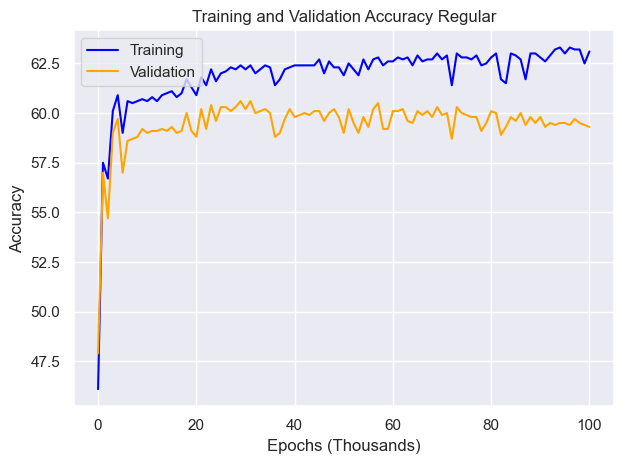

In [54]:
sns.set()
fig,ax = plt.subplots()
plt.plot([x * 100 for x in train_acc_arr11],c = 'blue',label = 'Training')
plt.plot([x * 100 for x in test_acc_arr11],c = 'orange',label = 'Validation')
leg = plt.legend(loc='upper left')
plt.xlabel('Epochs (Thousands)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Regular')
fig.tight_layout()
fig.savefig(iw_path + 'reg.eps')

In [55]:
# X,y = df.iloc[:,5:-1],df.Target

In [56]:
X_train, X_non_train, y_train,y_non_train = train_test_split(X[adv],y,train_size=.60,random_state = 50)
X_val, X_test, y_val,y_test = train_test_split(X_non_train,y_non_train,train_size=.50,random_state = 50)

In [57]:
from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(current_sched[normal_cols])
scaler = StandardScaler().fit(X_train)

In [58]:
# # current_sched[normal_cols] = scaler.transform(current_sched[normal_cols])
# X_train = pd.DataFrame(scaler.transform(X_train))
# X_val = pd.DataFrame(scaler.transform(X_val))
# X_test= pd.DataFrame(scaler.transform(X_test))

In [59]:
# X_train.columns = advanced
# X_val.columns = advanced
# X_test.columns = advanced
# X_train.columns = adv
# X_val.columns = adv
# X_test.columns = adv

In [60]:
class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 60)
    self.fc2 = nn.Linear(60, 30)
    self.fc3 = nn.Linear(30, 10)
    self.fc4 = nn.Linear(10, 5)
    self.fc5 = nn.Linear(5, 1)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    return torch.sigmoid(self.fc5(x))
#     return self.fc5(x)
net = Net(X_train.shape[1])
graph = make_dot(net(torch.randn((1, len(reg)))), params=dict(net.named_parameters()))
graph.render(filename=iw_path + 'advanced', format='eps')

'/Users/tonyowens/Documents/IW_Images/advanced.eps'

In [61]:
# X_train = torch.from_numpy(X_train.to_numpy()).float()
# y_train = torch.squeeze(torch.from_numpy(y_train.astype(bool).to_numpy()).float())

# X_val = torch.from_numpy(X_val.to_numpy()).float()
# y_val = torch.squeeze(torch.from_numpy(y_val.astype(bool).to_numpy()).float())

# X_test = torch.from_numpy(X_test.to_numpy()).float()
# y_test = torch.squeeze(torch.from_numpy(y_test.astype(bool).to_numpy()).float())
X_train = torch.from_numpy(X_train.astype(float).to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.astype(bool).to_numpy()).float())

X_val = torch.from_numpy(X_val.astype(float).to_numpy()).float()
y_val = torch.squeeze(torch.from_numpy(y_val.astype(bool).to_numpy()).float())

X_test = torch.from_numpy(X_test.astype(float).to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.astype(bool).to_numpy()).float())

In [62]:
# criterion = nn.HingeEmbeddingLoss()
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(net.parameters(), lr=1e-2)
optimizer = optim.ASGD(net.parameters(),lr = 1e-2)

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
net = net.to(device)
criterion = criterion.to(device)

In [64]:
# on 12k
train_acc_arr12 = []
test_acc_arr12 = []
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)
max_val_err = np.inf
for epoch in range(100_001):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    if epoch % 1000 == 0:
        train_acc = calculate_accuracy(y_train, y_pred)
        y_test_pred = net(X_val)
        y_test_pred = torch.squeeze(y_test_pred)
        test_loss = criterion(y_test_pred,y_val)
        test_acc = calculate_accuracy(y_val, y_test_pred)
        print(
        f'''epoch {epoch}
        Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
        Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
        ''')
        train_acc_arr12.append(np.round(np.float64(train_acc),3))
        test_acc_arr12.append(np.round(np.float64(test_acc),3))
    if test_loss < max_val_err:
        max_val_err = test_loss
        best_state = net.state_dict()
    for param in net.parameters():   
        param.grad = None
    train_loss.backward()
    optimizer.step()

epoch 0
        Train set - loss: 0.721, accuracy: 0.46
        Test  set - loss: 0.715, accuracy: 0.481
        
epoch 1000
        Train set - loss: 0.658, accuracy: 0.604
        Test  set - loss: 0.666, accuracy: 0.581
        
epoch 2000
        Train set - loss: 0.657, accuracy: 0.605
        Test  set - loss: 0.665, accuracy: 0.583
        
epoch 3000
        Train set - loss: 0.657, accuracy: 0.605
        Test  set - loss: 0.665, accuracy: 0.583
        
epoch 4000
        Train set - loss: 0.656, accuracy: 0.606
        Test  set - loss: 0.665, accuracy: 0.583
        
epoch 5000
        Train set - loss: 0.656, accuracy: 0.605
        Test  set - loss: 0.665, accuracy: 0.582
        
epoch 6000
        Train set - loss: 0.656, accuracy: 0.606
        Test  set - loss: 0.665, accuracy: 0.585
        
epoch 7000
        Train set - loss: 0.656, accuracy: 0.605
        Test  set - loss: 0.665, accuracy: 0.582
        
epoch 8000
        Train set - loss: 0.656, accuracy: 0.606


In [65]:
X_train.shape[1]

net1 = Net(X_train.shape[1])
# net1.load_state_dict(best_state)

In [66]:
net1.load_state_dict(best_state)
# test_preds = net1(X_test)
test_preds = np.round(net1(X_test).detach().numpy())
a = np.array([])
b = np.array([])

In [67]:
for y1 in y_test:
    b = np.append(b,y1)

for pred in test_preds:
    a = np.append(a,pred)

In [68]:
from sklearn.metrics import accuracy_score
accq = accuracy_score(b,a)
print(accuracy_score(b,a))
combinedq = pd.DataFrame(dict(actual =b ,prediction = a))
pd.crosstab(index=combinedq["actual"], columns = combinedq["prediction"])

0.5987155090390105


prediction,0.0,1.0
actual,,
0.0,1041,935
1.0,752,1476


In [69]:
acc_df = pd.DataFrame()
acc_df['Training'] = np.array(train_acc_arr12) * 100
acc_df['Validation'] = np.array(test_acc_arr12) * 100
print("Max validation accuracy = %.2f",max(test_acc_arr12))

Max validation accuracy = %.2f 0.59


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


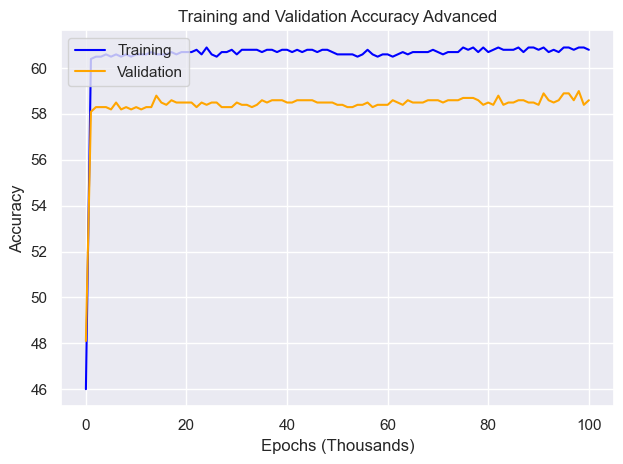

In [70]:
sns.set()
fig,ax = plt.subplots()
plt.plot([x * 100 for x in train_acc_arr12],c = 'blue',label = 'Training')
plt.plot([x * 100 for x in test_acc_arr12],c = 'orange',label = 'Validation')
leg = plt.legend(loc='upper left')
plt.xlabel('Epochs (Thousands)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Advanced')
fig.tight_layout()
fig.savefig(iw_path + 'advanced.eps')

In [71]:
X_train, X_non_train, y_train,y_non_train = train_test_split(X,y.astype(float),train_size=.60,random_state=50)
X_val, X_test, y_val,y_test = train_test_split(X_non_train,y_non_train,train_size=.50,random_state = 50)

In [72]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)

In [73]:
X_train = pd.DataFrame(scaler.transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
X_test= pd.DataFrame(scaler.transform(X_test))

In [74]:
X_train.columns = X.columns
X_val.columns = X.columns
X_test.columns = X.columns

In [75]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [77]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [78]:
all_mods = [LogisticRegression(),KNeighborsClassifier(),GradientBoostingClassifier(),RandomForestClassifier(),SVC()]

In [79]:
grids = {'LogisticRegression()':{
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C': np.linspace(0.01,1,11),
        'fit_intercept': [True, False],
    #     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [5000, 2500, 1000,1500,2000],
        'class_weight': [None, 'balanced'],
        'warm_start': [True, False]
    },'KNeighborsClassifier()':{'n_neighbors': np.int32(np.linspace(1,50,2)),
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]},'GradientBoostingClassifier()':{
        'n_estimators': np.int32(np.linspace(100,701,3)),
        'max_depth': [3,2,1],
        'learning_rate': [0.1, 0.05, 0.01],
    },'RandomForestClassifier()':{
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20],     # Maximum depth of the trees
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],   # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None] # Number of features to consider when looking for the best split
},'SVC()':{
        'C': np.linspace(0.01,1,4),
        'kernel': ['linear', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.1, 1,3,5],
        'degree': [2, 3, 4],
        'coef0': [-1, 0, 1]
    }}

In [80]:
import time

In [81]:
start_time = time.time()
fin_dict = {}
# for num,mod in enumerate(all_mods[:2] + [all_mods[3]]):
for num,mod in enumerate(all_mods):
    print(mod)
    for _,cols in enumerate([f_cols,reg,adv]):
        preds = mod.fit(X_train[cols],y_train).predict(X_test[cols])

        from sklearn.metrics import accuracy_score
        accq = accuracy_score(preds,y_test)
#         print(accuracy_score(preds,y_test))
        combinedq = pd.DataFrame(dict(actual =y_test ,prediction = preds))
        pd.crosstab(index=combinedq["actual"], columns = combinedq["prediction"])
        baseline_acq = accuracy_score(preds,y_test)
        # print(np.mean(cross_val_score(LogisticRegression().fit(X_train[f_cols],y_train),X_test[f_cols],y_test,cv = 10)))

        param_grid = grids[str(mod)]

            # Create an instance of the predictive model
        t_mod = mod.fit(X_train[cols],y_train)


        # Create a GridSearchCV object
        grid_search = GridSearchCV(t_mod, param_grid,n_jobs = -1,cv= 5)

        # Fit the GridSearchCV object to the data
        grid_search.fit(X_val[cols], y_val)

        df = pd.DataFrame(grid_search.cv_results_['params'])
        df['mean_score'] = grid_search.cv_results_['mean_test_score']
        df = df[df.mean_score.notnull()]

        df = df.sort_values(by = 'mean_score',ascending = 0)

        preds = grid_search.best_estimator_.predict(X_test[cols])
        accq = accuracy_score(preds,y_test)
#         print(accuracy_score(predd,y_test))
        test_acq = accuracy_score(preds,y_test)
        combinedq = pd.DataFrame(dict(actual =y_test ,prediction = preds))
        pd.crosstab(index=combinedq["actual"], columns = combinedq["prediction"])
        
        fin_dict[f"{str(t_mod).replace('()','')}_{_}"] = [baseline_acq,df,test_acq]

#         from sklearn.model_selection import cross_val_score
#         lr_t = np.mean(cross_val_score(lr_grid_search.best_estimator_,X_test[f_cols],y_test,cv = 10))
#         lr_t
end_time = time.time()
print(end_time - start_time)

LogisticRegression()


/Users/tonyowens/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tonyowens/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

KNeighborsClassifier()
GradientBoostingClassifier()
RandomForestClassifier()
SVC()
1225.2234289646149


In [82]:
for m in [x for x in list(fin_dict.keys()) if x.count('0') > 0]:
    print(m,fin_dict[m][0],fin_dict[m][-1])

LogisticRegression_0 0.601569933396765 0.5894386298763082
KNeighborsClassifier_0 0.5558991436726927 0.5682683158896289
GradientBoostingClassifier_0 0.5953853472882968 0.5932445290199809
RandomForestClassifier_0 0.5618458610846813 0.5768315889628924
SVC_0 0.5949096098953378 0.5756422454804948


In [86]:
for m in [x for x in list(fin_dict.keys()) if x.count('1') > 0]:
    print(m,fin_dict[m][0],fin_dict[m][-1])

LogisticRegression_1 0.6049000951474786 0.6063273073263559
KNeighborsClassifier_1 0.5525689819219791 0.5732635585156993
GradientBoostingClassifier_1 0.6046622264509991 0.5911037107516651
RandomForestClassifier_1 0.5694576593720266 0.5858705994291151
SVC_1 0.609895337773549 0.6068030447193149


In [87]:
for m in [x for x in list(fin_dict.keys()) if x.count('2') > 0]:
    print(m,fin_dict[m][0],fin_dict[m][-1])

LogisticRegression_2 0.5987155090390105 0.5875356803044719
KNeighborsClassifier_2 0.5558991436726927 0.5789724072312084
GradientBoostingClassifier_2 0.5972882968601332 0.5949096098953378
RandomForestClassifier_2 0.5727878211227403 0.5820647002854424
SVC_2 0.5920551855375833 0.5832540437678402


In [85]:
import pickle

# save the dictionary as a pickle object
filename = downloads_path + '/final_results_dict.pkl'

# open the file in read-binary mode
with open(filename, 'wb') as f:
    # load the dictionary using the pickle module
    pickle.dump(fin_dict,f)